In [16]:
import pandas as pd
import numpy as np
import keras
from keras.models import Sequential
from sklearn.utils import shuffle
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, matthews_corrcoef, accuracy_score, roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from Bio import SeqIO
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, Dropout, MaxPooling1D, Lambda, Conv2D, MaxPooling2D, Bidirectional, LSTM, ConvLSTM2D, Flatten
import os
import random
from  keras.regularizers import l2
from sklearn.preprocessing import PowerTransformer


In [17]:
def set_seed(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

train = pd.read_csv('Embeddings/Prot_t5/train_t5_pssm.csv')
val = pd.read_csv('Embeddings/Prot_t5/val_t5_pssm.csv')
test = pd.read_csv('Embeddings/Prot_t5/test_t5_pssm.csv')

# train = pd.concat([train, val])

print(train.shape)
print(val.shape)
print(test.shape)

# Make validation set imbalanced
val_pos = val[val['label'] == 1]
val_neg = val[val['label'] == 0]

val_pos_sampled = val_pos.sample(frac=0.2, random_state=42)
val_neg_sampled = val_neg.sample(frac=0.4, random_state=42)

val = pd.concat([val_pos_sampled, val_neg_sampled])

# Convert the embedding strings to numpy arrays
X_train_embeddings = train['embedding'].apply(lambda x: np.array([float(i) for i in x.strip('[]').split()]))
X_val_embeddings = val['embedding'].apply(lambda x: np.array([float(i) for i in x.strip('[]').split()]))
X_test_embeddings = test['embedding'].apply(lambda x: np.array([float(i) for i in x.strip('[]').split()]))

X_train_PSSM = train['PSSM'].apply(lambda x: np.array([float(i) for i in x.strip("[]").split()]))
X_val_PSSM = val['PSSM'].apply(lambda x: np.array([float(i) for i in x.strip("[]").split()]))
X_test_PSSM = test['PSSM'].apply(lambda x: np.array([float(i) for i in x.strip("[]").split()]))

X_train_PSSM = np.stack(X_train_PSSM.values)
X_val_PSSM = np.stack(X_val_PSSM.values)
X_test_PSSM = np.stack(X_test_PSSM.values)

# Convert to a numpy array if needed
X_train_embeddings = np.stack(X_train_embeddings.values)
X_val_embeddings = np.stack(X_val_embeddings.values)
X_test_embeddings = np.stack(X_test_embeddings.values)

# use power transform to normalize the pssm
scaler = PowerTransformer()
X_train_PSSM = scaler.fit_transform(X_train_PSSM)
X_val_PSSM = scaler.transform(X_val_PSSM)
X_test_PSSM = scaler.transform(X_test_PSSM)

# Extract sequences
X_train = train['sequence'].values
X_val = val['sequence'].values
X_test = test['sequence'].values

# Extract labels
y_train = train['label'].values
y_val = val['label'].values
y_test = test['label'].values

# Create a dictionary to map amino acids to integers
amino_acids = 'ACDEFGHIKLMNPQRSTVWY-'
aa_to_int = {aa: i for i, aa in enumerate(amino_acids)}

# Convert the sequences to a numerical format and convert to numpy arrays
X_train_num = [[aa_to_int[aa] for aa in seq] for seq in X_train]
X_val_num = [[aa_to_int[aa] for aa in seq] for seq in X_val]
X_test_num = [[aa_to_int[aa] for aa in seq] for seq in X_test]

X_train_num = np.array(X_train_num)
X_val_num = np.array(X_val_num)
X_test_num = np.array(X_test_num)

#print shapes
print(X_train_embeddings.shape)
print(X_val_embeddings.shape)
print(X_test_embeddings.shape)
print(X_train_PSSM.shape)
print(X_val_PSSM.shape)
print(X_test_PSSM.shape)
print(X_train_num.shape)
print(X_val_num.shape)
print(X_test_num.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)



(8411, 6)
(935, 6)
(3226, 6)
(8411, 1024)
(275, 1024)
(3226, 1024)
(8411, 20)
(275, 20)
(3226, 20)
(8411, 33)
(275, 33)
(3226, 33)
(8411,)
(275,)
(3226,)


In [18]:
from sklearn.metrics import accuracy_score, matthews_corrcoef, roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
def evaluate_model(model, X_val = None, X_val_pt5 = None, X_val_PSSM = None, y_val = None, print_metrics=True):
    y_true = y_val
    # Predict probabilities (or logits if using `from_logits=True`).
    if X_val_pt5 is None:
        y_pred_probs = model.predict(X_val)
    elif X_val is None:
        y_pred_probs = model.predict(X_val_pt5)
    elif X_val_PSSM is None:
        y_pred_probs = model.predict([X_val, X_val_pt5])
    else:
        y_pred_probs = model.predict([X_val, X_val_pt5, X_val_PSSM])

    # Convert probabilities/logits to binary predictions (threshold = 0.5).
    y_pred = (y_pred_probs > 0.5).astype(int)

    # If y_true is one-hot encoded, convert it to binary format
    if len(y_true.shape) > 1 and y_true.shape[1] > 1:  # Check if y_true is one-hot encoded
        y_true = np.argmax(y_true, axis=1)  # Convert one-hot encoded y_true to binary labels

    # Ensure y_pred is also 1D
    if len(y_pred.shape) > 1 and y_pred.shape[1] > 1:
        y_pred = np.argmax(y_pred, axis=1)  # Convert y_pred to binary labels if necessary

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)
    auprc = average_precision_score(y_true, y_pred_probs)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    # Compute Specificity
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)

    # Print the results
    if print_metrics:
        print(f'Accuracy: {accuracy:.4f}')
        print(f'MCC: {mcc:.4f}')
        print(f'AUC: {auc:.4f}')
        print(f'AUPRC: {auprc:.4f}')
        print(f'Precision: {precision:.4f}')
        print(f'Recall: {recall:.4f}')
        print(f'Specificity: {specificity:.4f}')
        print(f'F1 Score: {f1:.4f}')

    return accuracy, mcc, auc, auprc, precision, recall, specificity, f1

In [19]:
from tensorflow.keras.layers import Input, Dense, LSTM, Bidirectional, Dropout, Flatten, Attention, Conv1D, MaxPooling1D, Reshape
from tensorflow.keras.models import Model, Sequential
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

def create_MLP_model():
    input_shape = (1024,)  # 1024 features
    inputs = Input(shape=input_shape)

    dense1 = Dense(256, activation='relu')(inputs)
    dropout1 = Dropout(0.4)(dense1)
    dense2 = Dense(64, activation='relu')(dropout1)
    dropout2 = Dropout(0.4)(dense2)
    dense3 = Dense(16, activation='relu')(dropout2)
    outputs = Dense(1, activation='sigmoid')(dense3)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_CNN_model():
    input_shape = (1024, 1)  # 1024 features with 1 channel
    inputs = Input(shape=input_shape)

    # conv1 = Conv1D(256, 3, activation='relu')(inputs)
    # pool1 = MaxPooling1D(3)(conv1)
    # conv2 = Conv1D(128, 3, activation='relu')(pool1)
    # pool2 = MaxPooling1D(3)(conv2)
    conv3 = Conv1D(8, 3, activation='relu')(inputs)
    pool3 = MaxPooling1D(3)(conv3)
    flat = Flatten()(pool3)
    # dense1 = Dense(256, activation='relu')(flat)
    outputs = Dense(1, activation='sigmoid')(flat)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [14]:
# The training and evaluation part remains the same
model_names = [ 'RF', 'SVM', 'XGBoost', 'MLP', 'Conv1D' ]

# Create a dictionary to store the results
results = {name: [] for name in model_names}

# Train and evaluate the models
for name in model_names:
    print(f'\n{name}:')
    if name in ['RF', 'SVM', 'XGBoost']:
        if name == 'RF':
            model = RandomForestClassifier(n_estimators=100, random_state=42)
        elif name == 'SVM':
            model = SVC(random_state=42)
        elif name == 'XGBoost':
            model = XGBClassifier(random_state=42)
        model.fit(X_train_embeddings, y_train)
        results[name] = evaluate_model(model, X_val=X_val_embeddings, y_val=y_val)
    else:
        if name == 'MLP':
            model = create_MLP_model()
            X_train_embeddings = np.concatenate([X_train_embeddings, X_val_embeddings])
            y_train = np.concatenate([y_train, y_val])
        elif name == 'Conv1D':
            model = create_CNN_model()
            X_train_embeddings = X_train_embeddings.reshape(-1, 1024, 1)
            X_val_embeddings = X_val_embeddings.reshape(-1, 1024, 1)
            X_test_embeddings = X_test_embeddings.reshape(-1, 1024, 1)
        model.fit(X_train_embeddings, y_train, batch_size=64, epochs=50, verbose=1, validation_data=(X_val_embeddings, y_val)
                  , callbacks=[EarlyStopping(patience=5, restore_best_weights=True)])
        results[name] = evaluate_model(model, X_val=X_val_embeddings, y_val=y_val)

# Print the results
print('\nResults:')
for name in model_names:
    print(f'\n{name}:')
    for metric, result in zip(['Accuracy', 'MCC', 'AUC', 'AUPRC', 'Precision', 'Recall', 'Specificity', 'F1'], results[name]):
        print(f'{metric}: {result:.4f}')

# Plot the results using df.plot
results_df = pd.DataFrame(results, index=['Accuracy', 'MCC', 'AUC', 'AUPRC', 'Precision', 'Recall', 'Specificity', 'F1'])



RF:
Accuracy: 0.6727
MCC: 0.3464
AUC: 0.6802
AUPRC: 0.4833
Precision: 0.5344
Recall: 0.7071
Specificity: 0.6534
F1 Score: 0.6087

SVM:
Accuracy: 0.7418
MCC: 0.4925
AUC: 0.7563
AUPRC: 0.5588
Precision: 0.6061
Recall: 0.8081
Specificity: 0.7045
F1 Score: 0.6926

XGBoost:
Accuracy: 0.7200
MCC: 0.4470
AUC: 0.7326
AUPRC: 0.5337
Precision: 0.5833
Recall: 0.7778
Specificity: 0.6875
F1 Score: 0.6667

MLP:
Epoch 1/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5988 - loss: 0.6560 - val_accuracy: 0.7309 - val_loss: 0.5275
Epoch 2/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7201 - loss: 0.5535 - val_accuracy: 0.7636 - val_loss: 0.4746
Epoch 3/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7515 - loss: 0.5107 - val_accuracy: 0.7745 - val_loss: 0.4480
Epoch 4/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7637 - loss: 0.4865 - val_accuracy: 0.8073 - val_loss: 0.4375
Epoch 5/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7978 - loss: 0.4421 


Training RF...

Training SVM...

Training XGBoost...

Training MLP...
Epoch 1/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5935 - loss: 0.6577 - val_accuracy: 0.7382 - val_loss: 0.5277
Epoch 2/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7245 - loss: 0.5503 - val_accuracy: 0.7673 - val_loss: 0.4874
Epoch 3/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7502 - loss: 0.5121 - val_accuracy: 0.7818 - val_loss: 0.4329
Epoch 4/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7779 - loss: 0.4743 - val_accuracy: 0.7927 - val_loss: 0.4438
Epoch 5/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7866 - loss: 0.4529 - val_accuracy: 0.8291 - val_loss: 0.3638
Epoch 6/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8209 - loss: 0.3939 - val_accuracy: 0.8727 - val_loss: 0.3082
Epoch 7/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8492 - loss: 0.3414 - val_accuracy: 0.9055 - val_loss: 0.2417
Epoch 8/50
136/136 ━━━━━━━━━━━━━━

C:\Users\Admin\AppData\Local\Temp\ipykernel_8472\404668452.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=metric_results, x="Model", y="Score", palette="Set2")


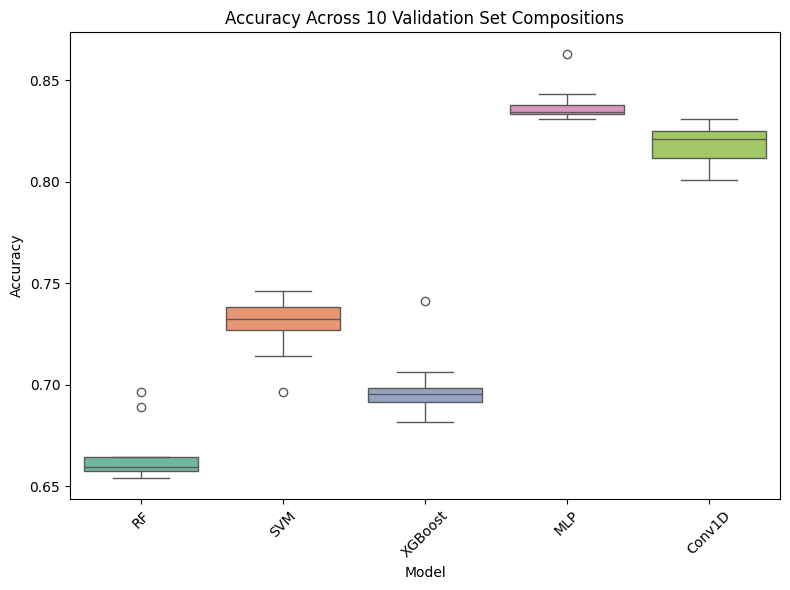

C:\Users\Admin\AppData\Local\Temp\ipykernel_8472\404668452.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=metric_results, x="Model", y="Score", palette="Set2")


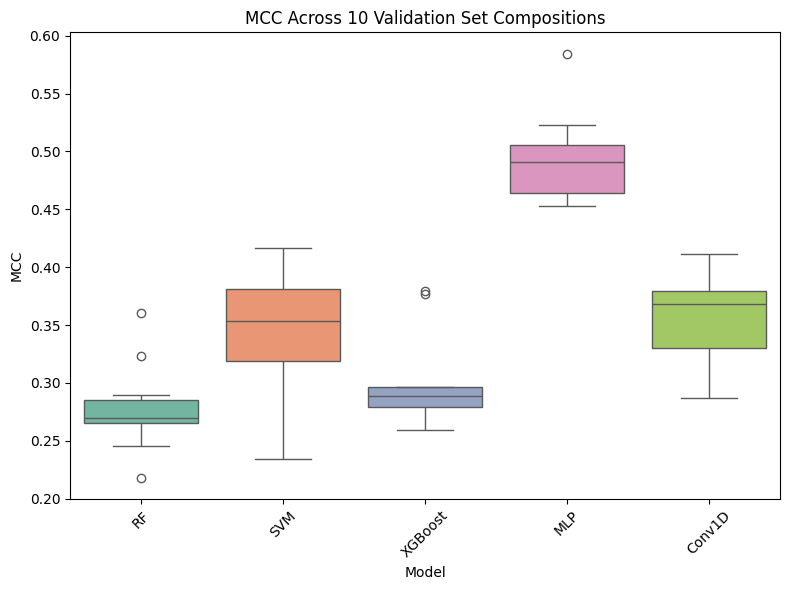

C:\Users\Admin\AppData\Local\Temp\ipykernel_8472\404668452.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=metric_results, x="Model", y="Score", palette="Set2")


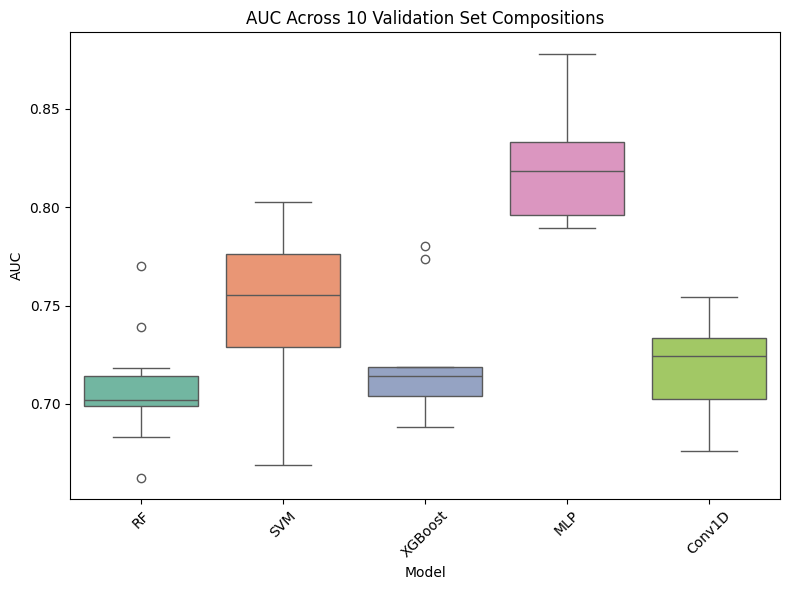

C:\Users\Admin\AppData\Local\Temp\ipykernel_8472\404668452.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=metric_results, x="Model", y="Score", palette="Set2")


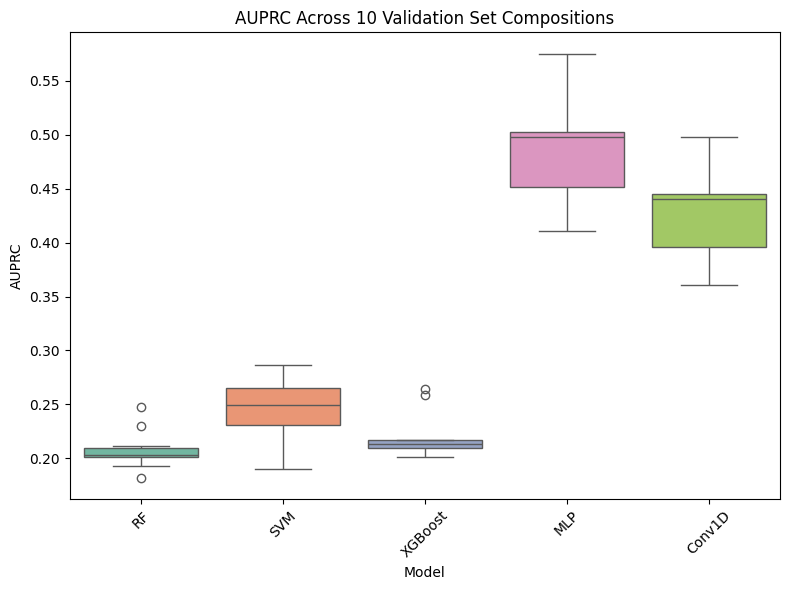

C:\Users\Admin\AppData\Local\Temp\ipykernel_8472\404668452.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=metric_results, x="Model", y="Score", palette="Set2")


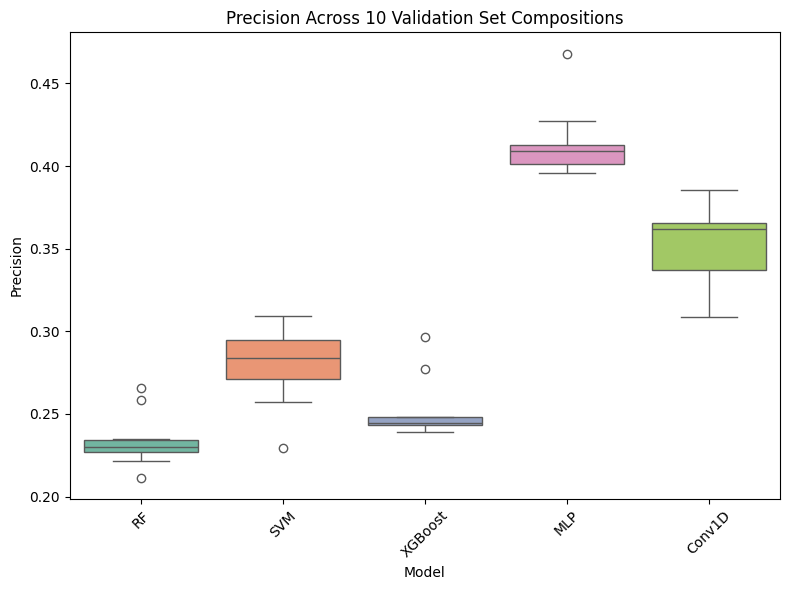

C:\Users\Admin\AppData\Local\Temp\ipykernel_8472\404668452.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=metric_results, x="Model", y="Score", palette="Set2")


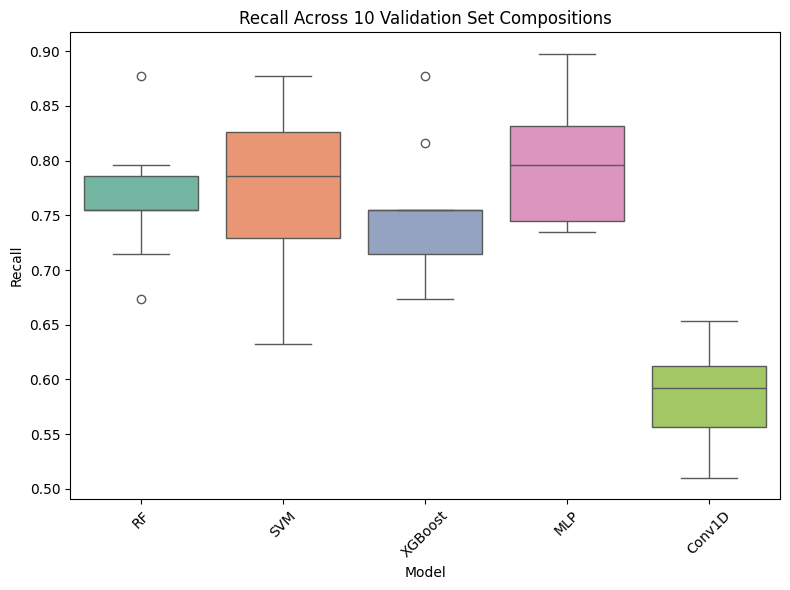

C:\Users\Admin\AppData\Local\Temp\ipykernel_8472\404668452.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=metric_results, x="Model", y="Score", palette="Set2")


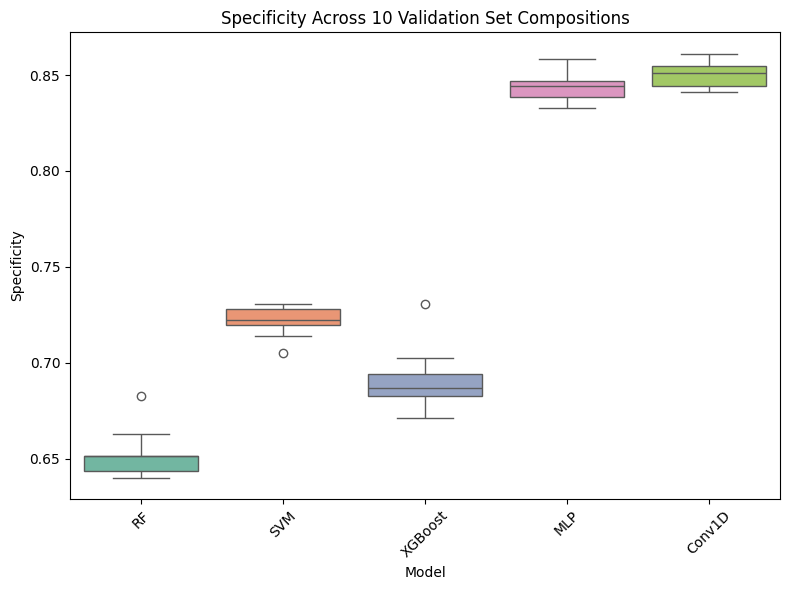

C:\Users\Admin\AppData\Local\Temp\ipykernel_8472\404668452.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=metric_results, x="Model", y="Score", palette="Set2")


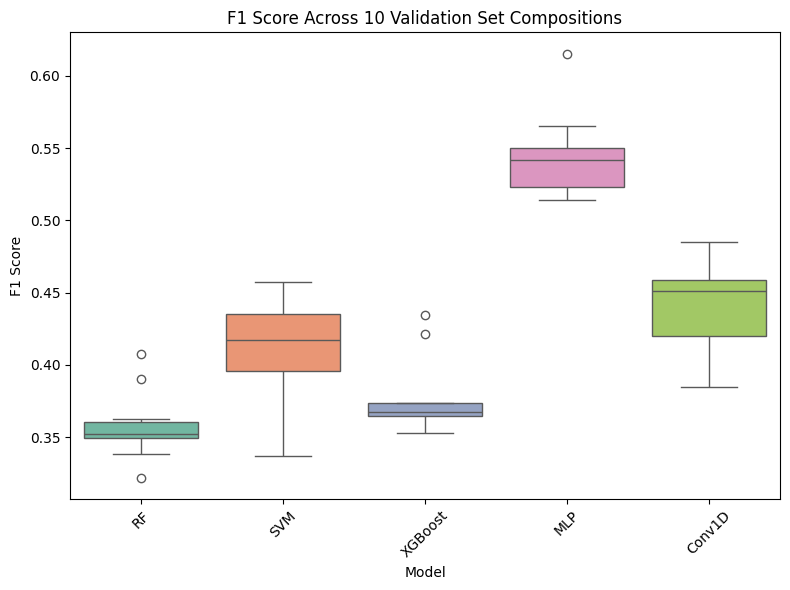


Mean ± Std Results:
Conv1D - AUC: 0.7178 ± 0.0250
Conv1D - AUPRC: 0.4277 ± 0.0484
Conv1D - Accuracy: 0.8177 ± 0.0101
Conv1D - F1 Score: 0.4391 ± 0.0319
Conv1D - MCC: 0.3541 ± 0.0395
Conv1D - Precision: 0.3512 ± 0.0249
Conv1D - Recall: 0.5857 ± 0.0462
Conv1D - Specificity: 0.8499 ± 0.0068
MLP - AUC: 0.8198 ± 0.0277
MLP - AUPRC: 0.4850 ± 0.0482
MLP - Accuracy: 0.8378 ± 0.0097
MLP - F1 Score: 0.5444 ± 0.0297
MLP - MCC: 0.4939 ± 0.0394
MLP - Precision: 0.4139 ± 0.0210
MLP - Recall: 0.7959 ± 0.0544
MLP - Specificity: 0.8436 ± 0.0075
RF - AUC: 0.7078 ± 0.0296
RF - AUPRC: 0.2079 ± 0.0187
RF - Accuracy: 0.6659 ± 0.0146
RF - F1 Score: 0.3577 ± 0.0246
RF - MCC: 0.2779 ± 0.0397
RF - Precision: 0.2337 ± 0.0163
RF - Recall: 0.7633 ± 0.0537
RF - Specificity: 0.6524 ± 0.0125
SVM - AUC: 0.7508 ± 0.0407
SVM - AUPRC: 0.2467 ± 0.0292
SVM - Accuracy: 0.7291 ± 0.0145
SVM - F1 Score: 0.4120 ± 0.0360
SVM - MCC: 0.3466 ± 0.0550
SVM - Precision: 0.2800 ± 0.0235
SVM - Recall: 0.7796 ± 0.0768
SVM - Specificity:

In [20]:
import seaborn as sns
# Train all models once
trained_models = {}
model_names = [ 'RF', 'SVM', 'XGBoost', 'MLP', 'Conv1D' ]

for name in model_names:
    print(f'\nTraining {name}...')
    if name in ['RF', 'SVM', 'XGBoost']:
        if name == 'RF':
            model = RandomForestClassifier(n_estimators=100, random_state=42)
        elif name == 'SVM':
            model = SVC(random_state=42, probability=True)
        elif name == 'XGBoost':
            model = XGBClassifier(random_state=42)
        model.fit(X_train_embeddings, y_train)
    else:
        if name == 'MLP':
            model = create_MLP_model()
            X_train_embeddings = np.concatenate([X_train_embeddings, X_val_embeddings])
            y_train = np.concatenate([y_train, y_val])
        elif name == 'Conv1D':
            model = create_CNN_model()
            X_train_embeddings = X_train_embeddings.reshape(-1, 1024, 1)
        model.fit(X_train_embeddings, y_train, batch_size=64, epochs=50, verbose=1, validation_data=(X_val_embeddings, y_val),
                  callbacks=[EarlyStopping(patience=5, restore_best_weights=True)])
    trained_models[name] = model

# Initialize the results dictionary
all_results = []

# Perform 10 iterations with different validation set compositions
num_iterations = 10
for iteration in range(num_iterations):
    print(f"\n--- Iteration {iteration + 1} ---")
    
    # Sample 10% of the positive validation set
    val_pos_sampled = val_pos.sample(frac=0.1, random_state=iteration)
    val_neg_sampled = val_neg.sample(frac=0.8, random_state=iteration)
    val_sampled = pd.concat([val_pos_sampled, val_neg_sampled])
    
    # Extract embeddings and labels for the sampled validation set
    X_val_sampled = np.stack(val_sampled['embedding'].apply(lambda x: np.array([float(i) for i in x.strip("[]").split()])).values)
    y_val_sampled = val_sampled['label'].values

    # Evaluate each model on the sampled validation set
    for name, model in trained_models.items():
        print(f'Evaluating {name}...')
        if name == '1DCNN':
            X_val_sampled = X_val_sampled.reshape(-1, 1024, 1)
        scores = evaluate_model(model, X_val=X_val_sampled, y_val=y_val_sampled)
        
        # Append the results
        for metric, score in zip(['Accuracy', 'MCC', 'AUC', 'AUPRC', 'Precision', 'Recall', 'Specificity', 'F1 Score'], scores):
            all_results.append({
                'Model': name,
                'Metric': metric,
                'Score': score,
                'Iteration': iteration
            })

# Convert all_results into a DataFrame
results_df = pd.DataFrame(all_results)

# Plot separate boxplots for each metric
metrics = results_df['Metric'].unique()
for metric in metrics:
    metric_results = results_df[results_df['Metric'] == metric]
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=metric_results, x="Model", y="Score", palette="Set2")
    plt.title(f"{metric} Across 10 Validation Set Compositions")
    plt.ylabel(metric)
    plt.xlabel("Model")
    plt.xticks(rotation=45)
    plt.tight_layout()
    # Save each plot
    plt.savefig(f"Plots/Model Selection/Prot_t5/Prot_t5_{metric}_boxplot.pdf", format="pdf")
    plt.show()

# Print mean ± std for each metric and model
print("\nMean ± Std Results:")
summary_results = results_df.groupby(['Model', 'Metric'])['Score'].agg(['mean', 'std'])
for (model, metric), stats in summary_results.iterrows():
    mean, std = stats['mean'], stats['std']
    print(f"{model} - {metric}: {mean:.4f} ± {std:.4f}")


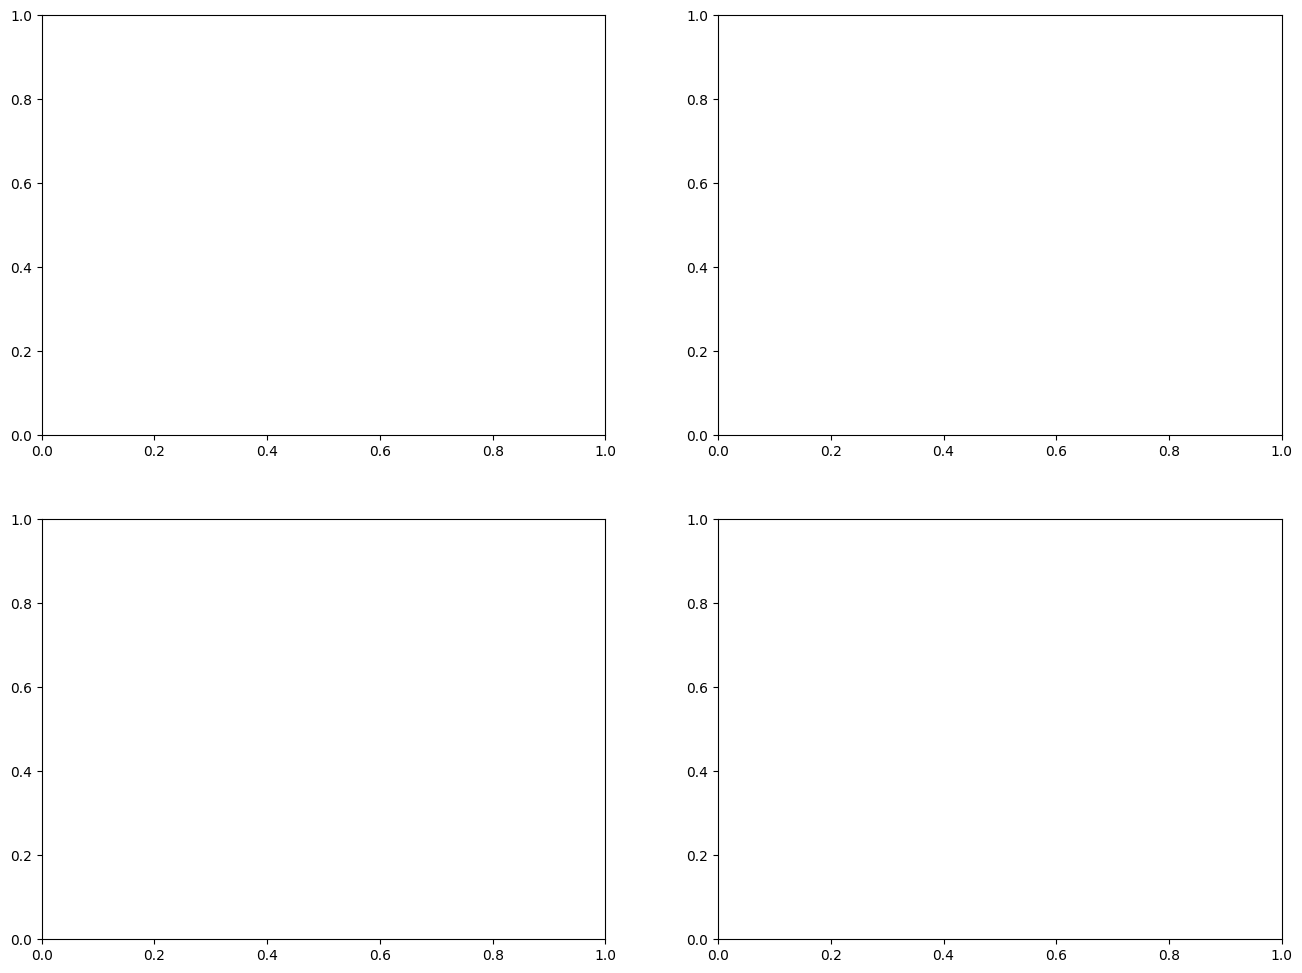

In [21]:
# Select the metrics to display
selected_metrics = ['Accuracy', 'MCC', 'AUC', 'AUPRC', 'Specificity', 'F1 Score']

# Initialize the figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))  # Create a 2x2 grid
axes = axes.flatten()  # Flatten for easy indexing
new_results_df = results_df[results_df['Metric'].isin(selected_metrics)]
# Iterate through the selected metrics and create a boxplot for each
# for i, metric in enumerate(selected_metrics):
#     metric_results = results_df[results_df['Metric'] == metric]
#     sns.boxplot(
#         data=metric_results, 
#         x="Model", 
#         y="Score", 
#         palette="Set2", 
#         ax=axes[i]
#     )
#     axes[i].set_title(f"{metric} Across 10 Validation Set Compositions", fontsize=14)
#     axes[i].set_ylabel(metric, fontsize=12)
#     axes[i].set_xlabel("Model", fontsize=12)
#     axes[i].tick_params(axis='x', rotation=45, labelsize=10)

# # Adjust layout to prevent overlap
# plt.tight_layout()

# # Save the entire figure as a PDF
# # plt.savefig("Plots/Model Selection/Prot_t5/Prot_t5_metrics_subplot.pdf", format="pdf")

# # Show the combined plot
# plt.show()

# # Print mean ± std for each metric and model
# print("\nMean ± Std Results:")
# summary_results = results_df.groupby(['Model', 'Metric'])['Score'].agg(['mean', 'std'])
# for (model, metric), stats in summary_results.iterrows():
#     mean, std = stats['mean'], stats['std']
#     print(f"{model} - {metric}: {mean:.4f} ± {std:.4f}")


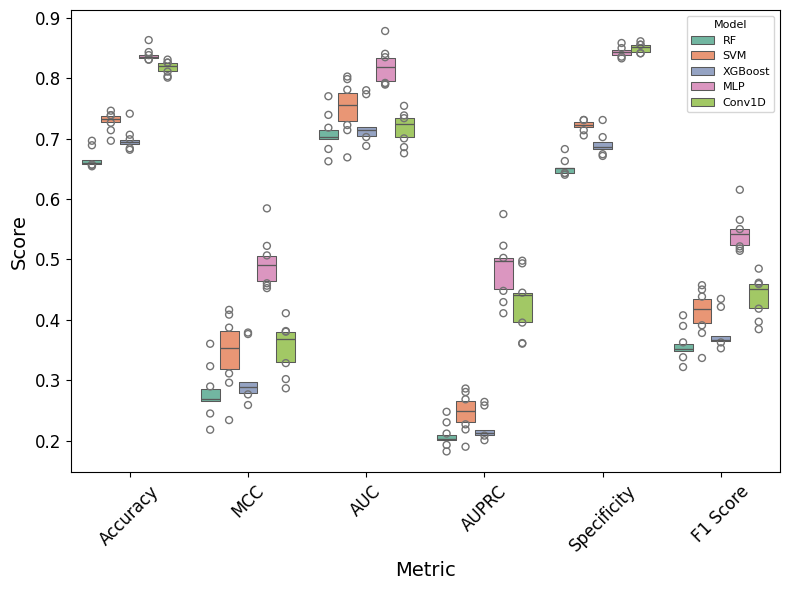

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create violin plots for each metric to visualize all results
plt.figure(figsize=(8, 6))
sns.boxenplot(data=new_results_df, x="Metric", y="Score", hue='Model', palette="Set2")

# Customize font sizes
# plt.title(f"Model Performance Metrics Validation Set Compositions", fontsize=16)  # Increase title font size
plt.ylabel("Score", fontsize=14)  # Increase y-axis label font size
plt.xlabel("Metric", fontsize=14)  # Increase x-axis label font size
plt.xticks(rotation=45, fontsize=12)  # Increase x-tick font size
plt.yticks(fontsize=12)  # Increase y-tick font size
plt.legend(title='Model', fontsize=8, title_fontsize=8)  # Customize legend font sizes

# Adjust layout and save the plot
plt.tight_layout()
plt.savefig('Plots/Model Selection/Prot_t5/Prot_t5_Model_Comparison_new.pdf', format='pdf')
plt.show()


In [23]:
# Print mean ± std for each metric and model in a tabular format
print("\nMean ± Std Results in Tabular Format:")
summary_results = results_df.groupby(['Model', 'Metric'])['Score'].agg(['mean', 'std']).reset_index()

# Format mean ± std as a single column
summary_results['Mean ± Std'] = summary_results.apply(
    lambda row: f"{row['mean']:.4f} ± {row['std']:.4f}", axis=1)

# Pivot the table to have metrics as columns and models as rows
summary_table = summary_results.pivot(index='Model', columns='Metric', values='Mean ± Std')

# Print the table
print(summary_table.to_string())

# Optionally save to a CSV or Markdown file
summary_table.to_csv("Plots/Model Selection/Prot_t5/mean_std_results.csv")




Mean ± Std Results in Tabular Format:
Metric               AUC            AUPRC         Accuracy               F1              MCC        Precision           Recall      Specificity
Model                                                                                                                                          
1DCNN    0.7254 ± 0.0340  0.4385 ± 0.0659  0.8249 ± 0.0111  0.4520 ± 0.0420  0.3698 ± 0.0520  0.3650 ± 0.0308  0.5939 ± 0.0656  0.8569 ± 0.0063
MLP      0.8130 ± 0.0173  0.5054 ± 0.0593  0.8152 ± 0.0054  0.5164 ± 0.0153  0.4667 ± 0.0222  0.3791 ± 0.0098  0.8102 ± 0.0373  0.8159 ± 0.0067
RF       0.7078 ± 0.0296  0.2079 ± 0.0187  0.6659 ± 0.0146  0.3577 ± 0.0246  0.2779 ± 0.0397  0.2337 ± 0.0163  0.7633 ± 0.0537  0.6524 ± 0.0125
SVM      0.7508 ± 0.0407  0.2467 ± 0.0292  0.7291 ± 0.0145  0.4120 ± 0.0360  0.3466 ± 0.0550  0.2800 ± 0.0235  0.7796 ± 0.0768  0.7221 ± 0.0082
XGBoost  0.7219 ± 0.0305  0.2212 ± 0.0217  0.6983 ± 0.0167  0.3783 ± 0.0271  0.3020 ± 0.0414  0.2

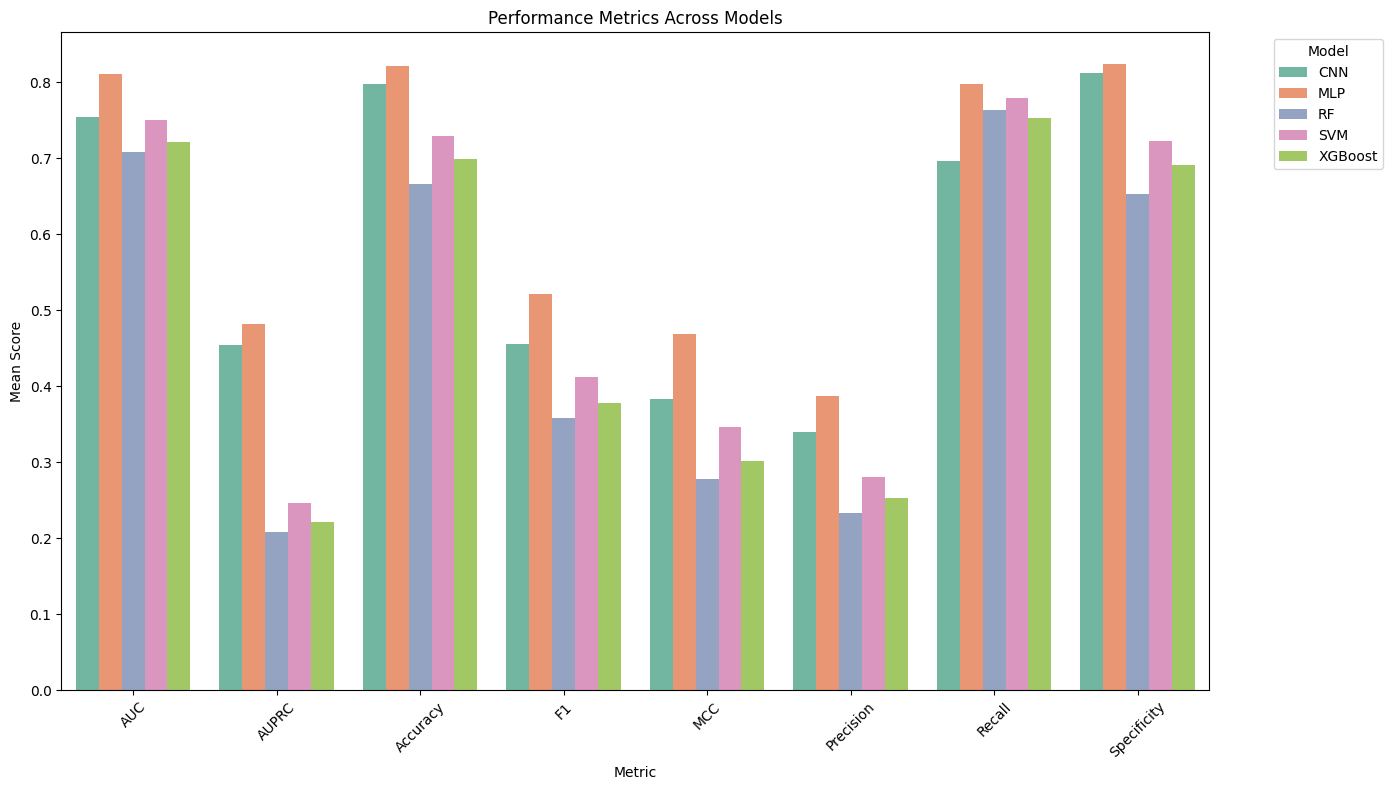

In [20]:
# Melt the summary table to long format for grouped bar plotting
melted_data = summary_table.reset_index().melt(id_vars=["Model"], var_name="Metric", value_name="Score")

# Extract mean scores (ignoring standard deviations) for plotting
melted_data["Mean"] = melted_data["Score"].apply(lambda x: float(x.split(" ± ")[0]))

# Plot grouped bar chart with metrics on the X-axis and models as colors
plt.figure(figsize=(14, 8))
sns.barplot(data=melted_data, x="Metric", y="Mean", hue="Model", palette="Set2")
plt.title("Performance Metrics Across Models")
plt.ylabel("Mean Score")
plt.xlabel("Metric")
plt.xticks(rotation=45)
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.savefig("Plots/Model Selection/Prot_t5/grouped_bar_results.pdf", format="pdf")
plt.show()
